# Visium DLPFC

In this notebook we demonstrate how mosna can be used to analyze spatiallly resolved omics data.  
The data used is from the publication by [Maynard et al.](https://www.nature.com/articles/s41593-020-00787-0) "Transcriptome-scale spatial gene expression in the human dorsolateral prefrontal cortex".  
Here 12 samples were processed with the [Visium](https://www.science.org/doi/10.1126/science.aaf2403) platform to produce maps of transcripts per spots.  

## Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
import warnings
import joblib
from pathlib import Path
from time import time
from tqdm import tqdm
import copy
import matplotlib as mpl
import napari
import colorcet as cc
import composition_stats as cs
from sklearn.impute import KNNImputer
from lifelines import KaplanMeierFitter, CoxPHFitter

import anndata as ad
import scanpy as sc
import scvi

from tysserand import tysserand as ty
from mosna import mosna

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams["savefig.facecolor"] = 'white'

Global seed set to 0


In [2]:
# If need to reload modules after their modification
from importlib import reload
ty = reload(ty)
mosna = reload(mosna)

### Objects data

Load files that contains all the detected objects (the cells) across all samples and clinical data.  
Data is available here: https://github.com/LieberInstitute/HumanPilot/tree/master and at [Globus](http://research.libd.org/globus/) (`jhpce#HumanPilot10x`).

In [3]:
data_dir = Path("../../HumanPilot/10X/")
sample_ids = [
    '151507', 
    '151508', 
    '151509', 
    '151510', 
    '151669', 
    '151670', 
    '151671', 
    '151672', 
    '151673', 
    '151674', 
    '151675', 
    '151676'
]

In [4]:
annotations = pd.read_csv(data_dir / 'barcode_level_layer_map.tsv', sep='\t', header=None)
annotations.columns = ['barcodes', 'sample_id', 'layer']
annotations

,barcodes,sample_id,layer
0,AAACAACGAATAGTTC-1,151507,L1
1,AAACAAGTATCTCCCA-1,151507,L3
2,AAACAATCTACTAGCA-1,151507,L1
3,AAACACCAATAACTGC-1,151507,WM
4,AAACAGCTTTCAGAAG-1,151507,L6
...,...,...,...
47324,TTGTTGTGTGTCAAGA-1,151676,L6
47325,TTGTTTCACATCCAGG-1,151676,WM
47326,TTGTTTCATTAGTCTA-1,151676,WM
47327,TTGTTTCCATACAACT-1,151676,L6


In [5]:
annotations['sample_id'].value_counts()

sample_id
151509    4788
151510    4595
151508    4381
151507    4221
151671    4093
151672    3888
151669    3636
151674    3635
151673    3611
151675    3566
151670    3484
151676    3431
Name: count, dtype: int64

In [7]:
# # rename files to use `sc.read_visium`
# for sample_id in sample_ids:
#     path_dir = data_dir / f'{sample_id}'
#     path_dir_spatial = path_dir / 'spatial'
#     path_dir_spatial.mkdir(parents=True, exist_ok=True)

#     for path, directories, files in os.walk(path_dir):
#         for file in files:
#             if file.startswith(sample_id):
#                 new_name = file.replace(f'{sample_id}_', '')
#                 os.rename(os.path.join(path, file), os.path.join(path, new_name))
#             if file == 'tissue_positions_list.txt':
#                 os.rename(os.path.join(path, file), os.path.join(path_dir_spatial, 'tissue_positions_list.csv'))
#             elif file.endswith('res_image.png'):
#                 os.rename(os.path.join(path, file), os.path.join(path_dir_spatial, file))
#             elif file == 'scalefactors_json.json':
#                 os.rename(os.path.join(path, file), os.path.join(path_dir_spatial, file))

In [13]:
hvgs=5000

sample_id = sample_ids[0]
sample_dir = data_dir / f'{sample_id}'
adata = sc.read_visium(path=sample_dir)
adata.var_names_make_unique()

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=hvgs,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [16]:
adata

AnnData object with n_obs × n_vars = 4226 × 5000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

In [19]:
adata.uns['spatial'][sample_id]['images']['hires'].shape

(2000, 2000, 3)

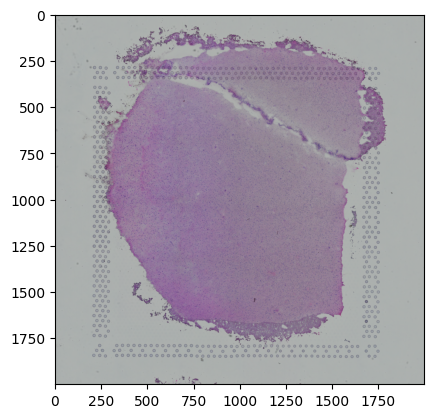

In [22]:
plt.imshow(adata.uns['spatial'][sample_id]['images']['hires']);

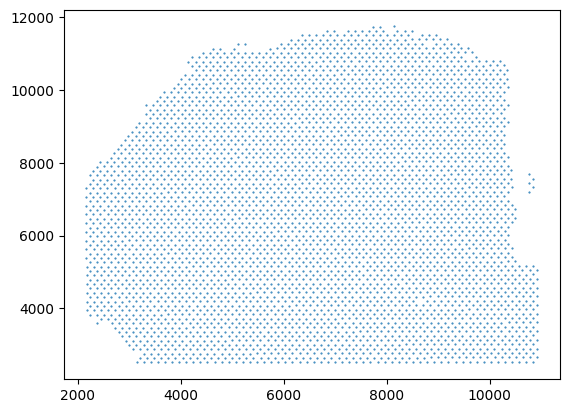

In [26]:
plt.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], s=1, marker='.')